<a href="https://colab.research.google.com/github/leoalexandre/mvp_adbp/blob/main/mvp_anp_seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Análise de Dados e Boas Práticas
Por Leonardo da Silva Alexandre

## 1.   Definição do Problema

O dataset utilizado neste projeto foi retirado do site da Agência Nacional do Petróleo (ANP). A criação do dataset foi realizada a partir da tabela de atributos retirada do shapefile de todos os programas sísmicos gerados pelo mercado de óleo e gás brasileiro, somado a aplicação de algumas regras presentes na legislação brasileira gerida pela ANP. A legislação nacional pode ser encontrada dentro dos sites da ANP. O shapefile está alocado mais precisamente em:

https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/dados-tecnicos/acervo-de-dados

O dataset apresenta atributos relacionados aos programas sísmicos com relação a datas, localização, volume, valor, empresas proprietárias dos dados e período de confidencialidade. Seu objetivo é vislumbrar novos processamentos ou aquisições sísmicas com maior potencial de interesse do mercado a partir da identificação de uma ausência de dados de processamento, e suas versões, em áreas das bacias sedimentares brasileiras que apresentem maior visibilidade da indústria de óleo e gás no momento.
Dentro de um cenário fictício, uma empresa de processamento sísmico utilizaria as informações para identificar um programa sísmico que teria maior relevância para ser reprocessado. Para isso, será necessário levar em consideração o cenário atual da exploração de petróleo no Brasil para classificar algumas das informações. Estas classificações poderiam posteriormente ser modificadas pelo próprio cenário do mercado de óleo e gás brasileiro ou a pedido de um potencial cliente.

Informações sobre atributos:

  1. **Vol_GB** – Volume da soma dos arquivos do projeto sísmico;
  2. **UDs** – Valor em UD do projeto sísmico;
  3. **Project** – Projeto sísmico oriundo de um programa sísmico;
  4. **Type_Proc** – Tipo de processamento sísmico realizado no programa sísmico;
  5. **Pub** – Classificação do programa sísmico em público ou confidencial;
  6. **Program** – Programa sísmico criado pela ANP por solicitação da empresa;
  7. **Type_Prog** – Classificação do programa sísmico em Exclusivo (Pré-98), Exclusivo, Não-Exclusivo ou de fomento;
  8. **Dim** – Dimensionalidade do dado sísmico;
  9. **date_start** – Data de início do programa;
  10. **date_end** – Data de término do programa;
  11. **time** - Tempo de existência do programa;
  12. **date_pub** – Data na qual o programa se torna público perante a legislação vigente;
  13. **Bloc** – Bloco exploratório onde está localizado o programa sísmico;
  14. **Field** – Campo de exploração onde está localizado o programa sísmico;
  15. **Basin** – Bacia geológica onde está localizado o programa sísmico;
  16. **EAD** – Empresa de Aquisição de Dados responsável pelo programa sísmico;
  17. **Operator** – Empresa Operadora detentora dos direitos sobre os dados do programa sísmico.

In [297]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import display
from statistics import mean

In [298]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Para a carga dos dados presentes em um arquivo de extensão csv será utilizado o pacote Pandas (Python Data Analysis Library). O arquivo se encontra armazenado na pasta pública no GitHub e será carregado diretamente do local. Um novo cabeçalho será inserido acompanhando a descrição prévia dos atributos. Após o carregamento do dataset realizado, os dados serão expostos para uma análise inicial.

In [299]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/leoalexandre/mvp_adbp/main/dados_anp_versao_MVP.csv"

# Informa o cabeçalho das colunas
colunas = ['Vol_GB', 'UDs', 'Project', 'Type_Proc', 'Pub', 'Program', 'Type_Prog', 'Dim', 'date_start','date_end', 'time', 'date_pub', 'Bloc', 'Field', 'Basin', 'EAD', 'Operator']

# Lê o arquivo utilizando as colunas informadas
dados_anp = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')


A seguir será exibida a parte inicial da tabela onde é possível visualizar uma pequena amostra dos dados e o novo cabeçalho.

In [300]:
# Mostra a parte inicial do dataset e seus atributos
dados_anp.head()

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN


## 3. Análise dos Dados

### 3.1 Estatísticas Descritivas

A análise inicial dos dados parte da visualização das dimensões do dataset, seguido das informações dos atributos e amostras de parte dos dados em tabelas.

In [301]:
# Mostra as dimensões do dataset
print(dados_anp.shape)

(5783, 17)


In [302]:
# Mostra as informações do dataset
print(dados_anp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Vol_GB      4643 non-null   float64
 1   UDs         4643 non-null   float64
 2   Project     5783 non-null   object 
 3   Type_Proc   5783 non-null   object 
 4   Pub         5783 non-null   object 
 5   Program     5783 non-null   object 
 6   Type_Prog   5783 non-null   object 
 7   Dim         5783 non-null   object 
 8   date_start  5783 non-null   object 
 9   date_end    5783 non-null   object 
 10  time        5783 non-null   int64  
 11  date_pub    5783 non-null   object 
 12  Bloc        5783 non-null   object 
 13  Field       5783 non-null   object 
 14  Basin       5782 non-null   object 
 15  EAD         5783 non-null   object 
 16  Operator    4239 non-null   object 
dtypes: float64(2), int64(1), object(14)
memory usage: 768.2+ KB
None


In [303]:
# Mostra as 10 primeiras linhas do dataset
dados_anp.head(10)

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
5,48.240106,9.648021,0022_GREATERBRASILSPAN,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
6,9.820742,1.964148,0022_GREATERBRASILSPAN_SUBSET1,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
7,3.920684,1.000000,0022_GREATERBRASILSPAN_SUBSET2,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
8,16.461309,3.292262,0022_GREATERBRASILSPAN_SUBSET4,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
9,13.980689,2.796138,0022_GREATERBRASILSPAN_SUBSET5,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN


In [304]:
# Mostra as 10 últimas linhas do dataset
dados_anp.tail(10)

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
5773,1.022351,1.0,R0392_BC10_LOFS_2016_4D_SC0360_M3,PSDM,Publico,R0392_BC10_LOFS_2016_4D_SC0360,Exclusivo,Sismica 3D,28/04/2016,17/11/2016,7,17/11/2021,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5774,0.292222,1.0,R0392_BC10_LOFS_2018_4D_BS,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5775,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M3,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5776,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M4,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5777,0.600385,1.0,R0392_BC10_LOFS_2020_4D_BS,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5778,0.600385,1.0,R0392_BC10_LOFS_2020_4D_M5,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5779,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_ALIGNED,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5780,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_SHIFT,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5781,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5782,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil


In [305]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dados_anp.describe()

,Vol_GB,UDs,time
count,4643.000000,4643.000000,5783.000000
mean,532.476506,11.941088,18.468615
std,8273.903989,84.314077,16.262781
min,0.000053,1.000000,0.000000
25%,0.366224,1.000000,5.000000
50%,5.219403,1.000000,11.000000
75%,26.434310,4.700951,29.000000
max,299061.045400,2990.610454,54.000000


Com o conhecimento prévio de alguns parametros dos dados sísmicos que são gerados pela industria do petróleo, sabemos que existem diferenças entre os dados processados e os dados de campo ou brutos **(Field Data)**. Em qualquer comparação de dados sísmicos é sabido que o volume dos dados brutos é consideravelmente superior ao dos dados processados.

Para o objetivo do trabalho é coerente manter os dados unificados no mesmo dataset, porém se torna extremamente relevante que sejam feitas algumas das análises separando essas duas visões dos dados. O dataset principal ao tratar de volume de dados será separado em dois subconjuntos de dados, um apenas com os dados brutos e outro apenas com os dados processados.



In [306]:
# Criando dataset alternativo sem a presença dos dados Brutos (Field Data)
df_s_fd= dados_anp.loc[dados_anp['Type_Proc'] != 'Field Data']

# Criando dataset alternativo apenas com dados Brutos (Field Data)
df_c_fd= dados_anp.loc[dados_anp['Type_Proc'] == 'Field Data']

# Fazendo um resumo estatístico do dataset alternativo sem a presença dos dados Brutos
df_s_fd.describe()

,Vol_GB,UDs,time
count,4470.000000,4470.000000,4517.000000
mean,42.132627,7.273900,15.660837
std,158.219959,18.483940,15.591414
min,0.000053,1.000000,0.000000
25%,0.334934,1.000000,4.000000
50%,4.073957,1.000000,8.000000
75%,23.411641,4.682328,23.000000
max,4251.282431,425.128243,54.000000


In [307]:
# Fazendo um resumo estatístico do dataset alternativo com a presença dos dados Brutos
df_c_fd.describe()

,Vol_GB,UDs,time
count,173.000000,173.000000,1266.000000
mean,13202.055344,132.532588,28.486572
std,40978.111952,409.617634,14.575475
min,0.090527,1.000000,3.000000
25%,8.953761,1.000000,16.000000
50%,65.244905,1.000000,26.000000
75%,2613.446031,26.134460,41.000000
max,299061.045400,2990.610454,54.000000


Com a separação dos dados em dois dataset alternativos fica mais evidente que ao se tratar de volume de dados ou valor deve ser levado em consideração os valores desses dataset pois o dataset completo pode superestimar os valores dos dados processados ou subestimar os valores dos dados brutos.

Agora vamos observar a distribuição das classes de maior importância para a resolução do problema inicial. Essas informações serão futuramente expostas e classificadas para a melhor manipulação e entendimento dos dados.

In [308]:
# Mostra a distribuição das classes de acordo com o tipo de processamento
print(dados_anp.groupby('Type_Proc').size())

Type_Proc
                        36
Field Data            1266
MIG FIN                688
MIG PRE-STK 3D RAW       1
MIG PRE-STK RAW          2
MIG PSDM                35
MIG PSTM               108
MIG PSTM C-WAVE          5
MIG RAW                 54
MIG VEL                  8
Other                  119
POST-STM               210
POSTSDM                  1
PSDM                  1886
PSTM                   887
STK FIN                445
STK RAW                 32
dtype: int64


In [309]:
# Mostra a distribuição das classes de acordo com a publicidade dos dados
print (dados_anp.groupby('Pub').size())

Pub
Confidencial    1956
Publico         3827
dtype: int64


In [310]:
# Mostra a distribuição das classes de acordo com a dimensionalidade dos dados
print (dados_anp.groupby('Dim').size())

Dim
Sismica 2D    2336
Sismica 3D    3429
Sismica_2D       7
Sismica_3D      11
dtype: int64


In [311]:
# Mostra a distribuição dos dados de acordo com a bacia sedimentar onde está localizado cada programa
print (dados_anp.groupby('Basin').size())

Basin
                           2
Acre                      20
Alagoas                   83
Almada                     1
Amazonas                 112
Araripe                    2
Barreirinhas              67
Camamu                    66
Campos                  1442
Ceara                    126
Cumuruxatiba              51
Espirito Santo           410
Foz do Amazonas          140
Jacuipe                   16
Jatoba                     4
Jequitinhonha             82
Madre de Dios              4
Marajo                     8
Mucuri                    30
Para - Maranhao           97
Parana                    95
Parecis - Alto Xingu      13
Parnaiba                 169
Pelotas                   65
Pernambuco - Paraiba      23
Potiguar                 503
Reconcavo                320
Rio do Peixe              11
Santos                   894
Sao Francisco             41
Sao Luis                   9
Sergipe                  246
Solimoes                 178
Tacutu                    10
Taubate 

Nas observações realizadas foi possível identificar alguns pontos onde será necessária a realização de ajustes nos dados. Como exemplo desses ajustes podemos elencar alguns dos problemas de ausência de informações no atributo relacionado as bacias sedimentares e ao tipo de processamento. Foi possível observar também problemas com relação a nomenclatura, tanto do atributo de dimensionalidade quanto a nomenclatura do tipo de processamento. Algumas informações de mesmo significado encontram-se com a nomenclatura escrita de forma diferente e precisarão ser corrigidas na etapa de pré-processamento junto com as informações faltantes também encontradas.

### 3.2 Visualizações Unimodais

Dentro dos atributos mais relevantes para o projeto, foram geradas algumas visualizações gráficas para o entendimento da distribuição dos dados. É observado nas distribuições com relação a quantidade de programas vinculados a bacia, tipo de processamento ou idade do programa o comportamento exponencial dos gráficos.

Text(0, 0.5, 'Qtd Projetos')

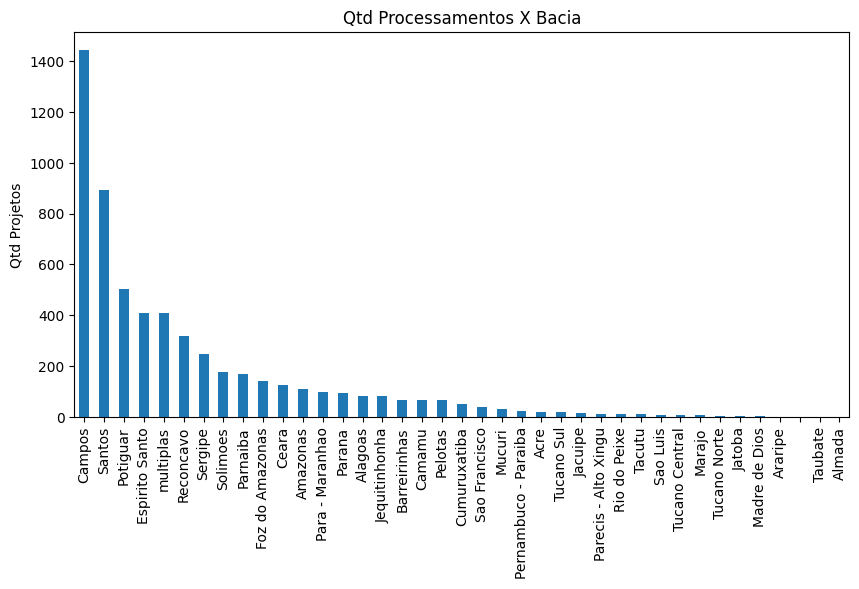

In [312]:
# Criando informação com a contagem por bacia
df_bacias = dados_anp['Basin'].value_counts()

# Plotando a quantidade de processamentos existente em cada bacia sedimentar
df_bacias.plot(kind= 'bar', figsize=(10,5))
plt.title('Qtd Processamentos X Bacia')
plt.ylabel('Qtd Projetos')

As bacias de Campos e Santos, reconhecidamente as mais produtivas no Brasil, justificam a quantidade de projetos inseridos em suas áreas. O investimento superior a bacias de menor expressão em termos de potencial exploratório também é evidenciado pelo gráfico se conectarmos a quantidade de projetos sísmicos realizados com o nível de investimento financeiro na área.

Text(0, 0.5, 'Qtd Projetos')

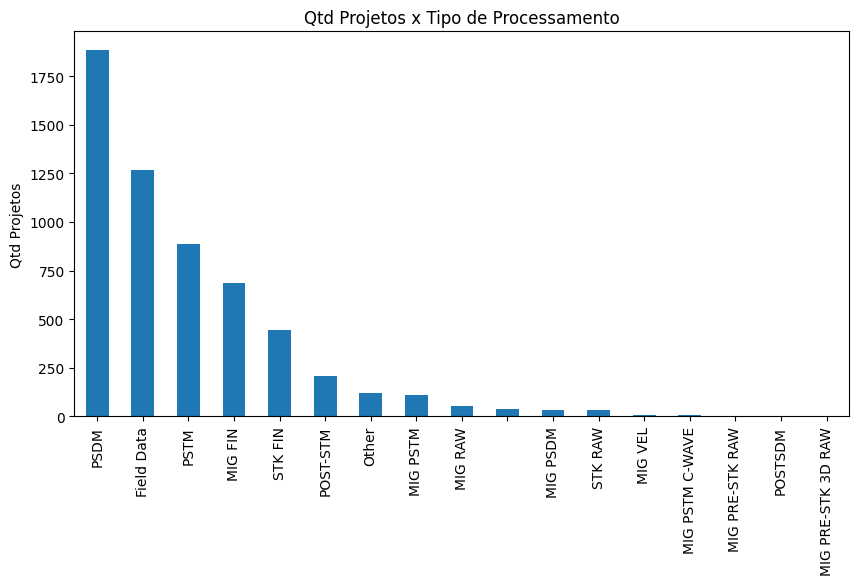

In [313]:
# Criando informação com a contagem por tipo de processamento
df_tipos = dados_anp['Type_Proc'].value_counts()

# Plotando a quantidade de tipos de processamentos
df_tipos.plot(kind= 'bar', figsize=(10,5))
plt.title('Qtd Projetos x Tipo de Processamento')
plt.ylabel('Qtd Projetos')

<Axes: xlabel='time', ylabel='Count'>

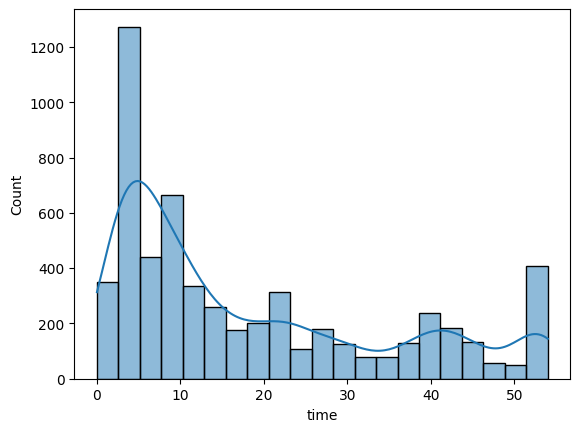

In [314]:
# Plotando o histograma do dados do atributo 'time'
sns.histplot(dados_anp['time'], kde= True)

O comportamento da distribuição seja por bacia ou tipo de processamento é bastante similar. Com relação a bacia, o gráfico demonstra uma preferência pelas bacias de Campos e Santos, com grande parte da distribução em ambas. O tipo de processamento mais presente no dataset é o PSDM, que de fato é o produto sísmico mais indicado para o auxílio na alocação de um poço exploratório.
A distribuição de acordo com o tempo de existência do programa exibe um pouco da história da exploração brasileira de petróleo, podendo ser observado os anos em que tivemos mais projetos sísmicos.

Continuaremos a análise com mais opções de visualização dos dados.

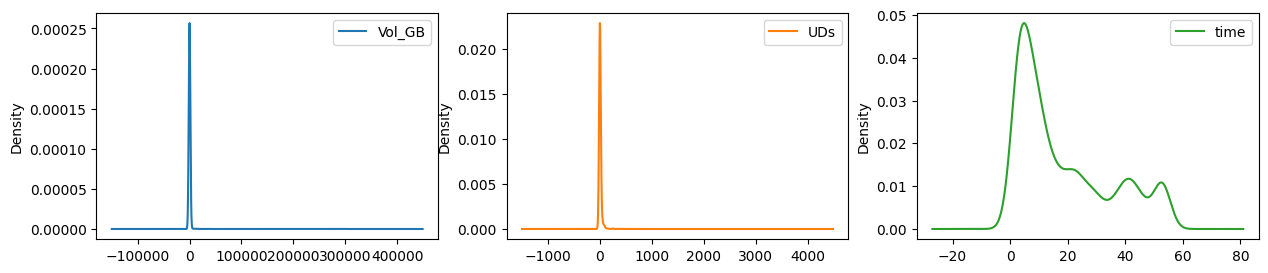

In [315]:
# Density Plot
dados_anp.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

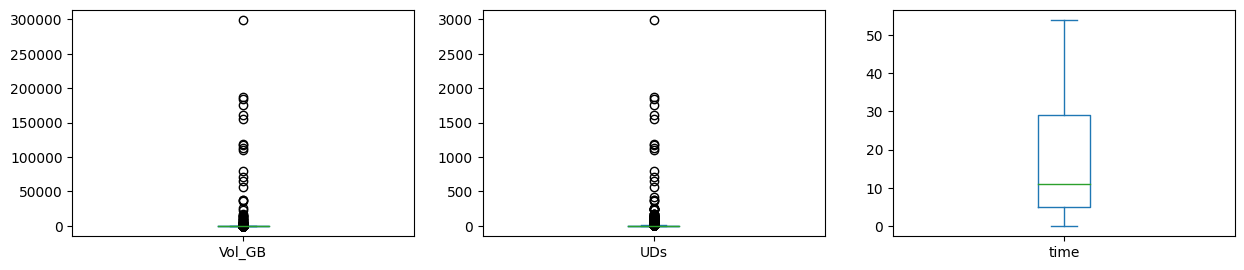

In [316]:
# Boxplot
dados_anp.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

O gráfico de densidade, assim como o boxplot expõem a falta de padrão no quesito de valor ou volume dos dados. Esse comportamento é esperado devido a complexidade que os dados sísmicos tem em relação ao volume.
O volume dos dados vem crescendo considerávelmente com a chegada de novas tecnologias de aquisição sísmica e com o aumento da capacidade de armazenamento dos bancos de dados das empresas. Apesar de se assemelhar a um outlier uma discrepância de volume ou valor é natural neste tipo de dado.
Como o valor do dado na ANP é diretamente proporcional ao volume, era previsível também que o comportamento das UDs fosse identico ao do volume.
A distribuição de acordo com o tempo de existência do programa desenha uma noção do crescimento da geração de dados sísmicos no Brasil nos últimos ano. Apesar da presença de projetos muito antigos, a mediana mostra que o histórico recente é de maior criação de dados sísmicos no território nacional.

Apenas por curiosidade faremos uma exploração dos dois subconjuntos de dados criados anteriormente.

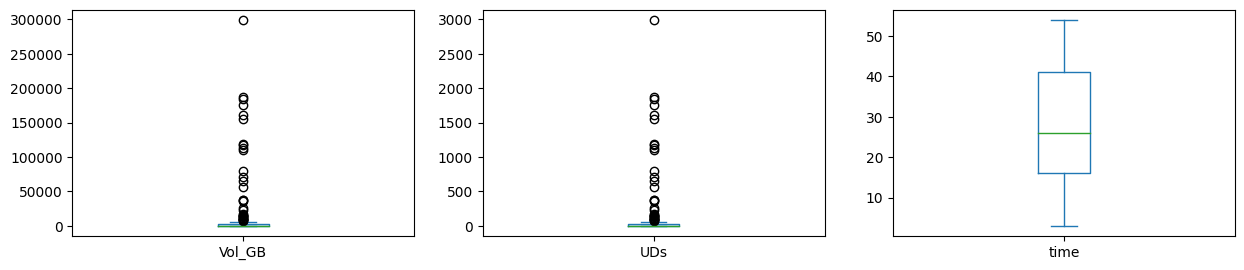

In [317]:
# Boxplot apenas dos dados brutos
df_c_fd.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

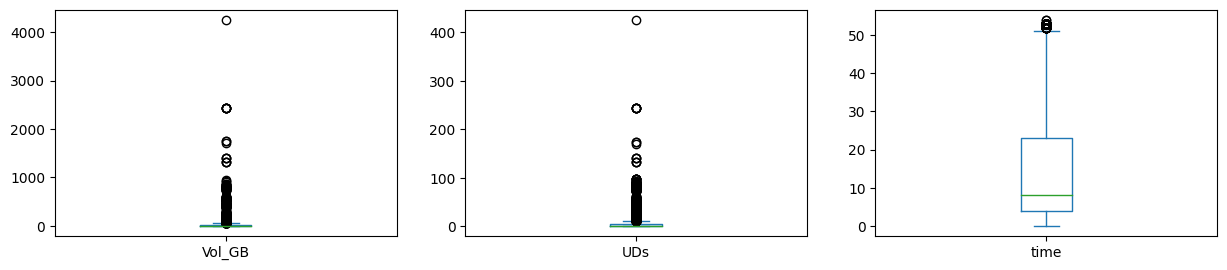

In [318]:
# Boxplot apenas dos dados processados
df_s_fd.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

Com os dois boxplot podemos observar o comportamento diferente da distribuição de volume e valor com os dados processados em relação aos dados brutos, esse indicativos sugerem uma atenção no momento de definições no pré-processamento, principalmente no tratamento de missings.
Observando os dados de idade dos projetos pode ser analisado como um aumento de dados processados nos últimos anos e uma queda na aquisição de dados brutos.

### 3.3 Visualizações Multimodais

Exiberemos agora uma matriz de correlação e dados de Scater Plot, para que seja possível mais alguma análise sobre o dataset da ANP.

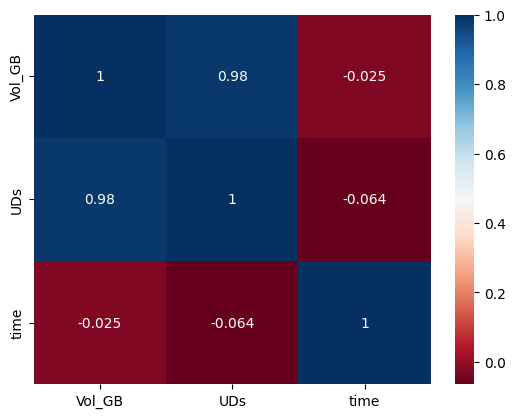

In [319]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dados_anp.corr(), annot=True, cmap='RdBu');

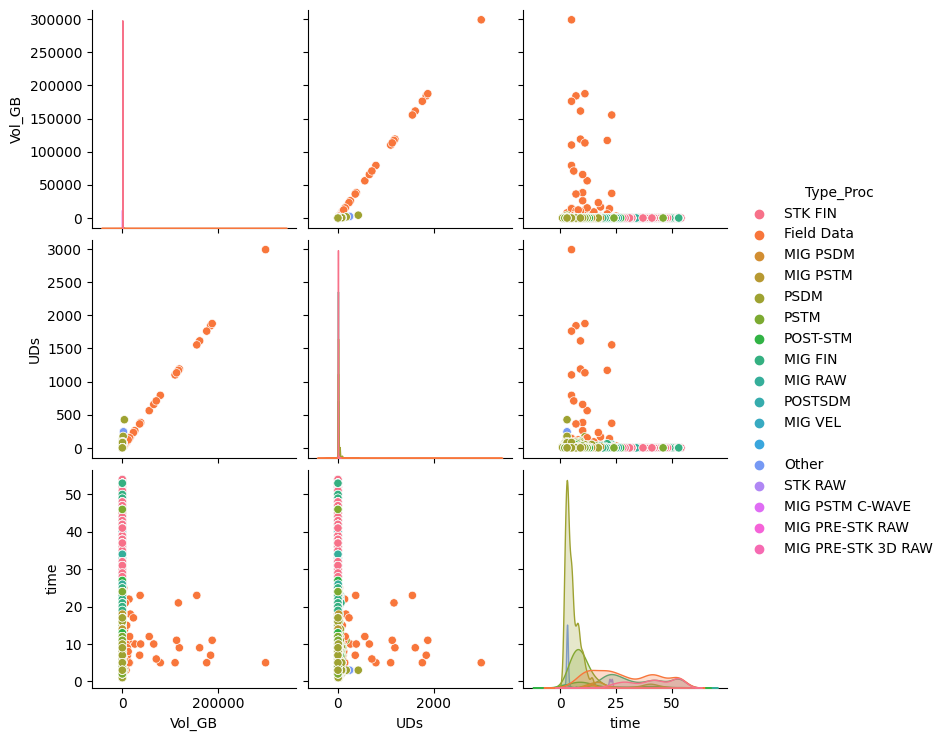

In [320]:
# Scatter Plot com Seaborn - Variação 1

sns.pairplot(dados_anp, hue = "Type_Proc", height = 2.5);

A matriz de correlação, juntamente com as retas diagonais presentes no Scater Plot, evidencia mais uma vez como os dados de volume e valor estão diretamente ligados, enquanto o tempo de existência do programa não apresenta uma conexão clara com nenhum dos outros atributos expostos. A retas diagonais nos gráficos são explicadas pela regra de definição de valor dos projetos na ANP, que leva em consideração exclusivamente a informação de volume dos dados.

Ainda atento a diferença entre dados de campo e dados processados, faremos mais uma análise com os subconjuntos de dados para tentar observar diferenças no comportamento dos dados.

A **variação 2** trará o subconjunto de dados **sem** os dados brutos (**Field Data**), enquanto a **variação 3** trará o subconjunto de dados **apenas** com os dados brutos (**Field Data**).

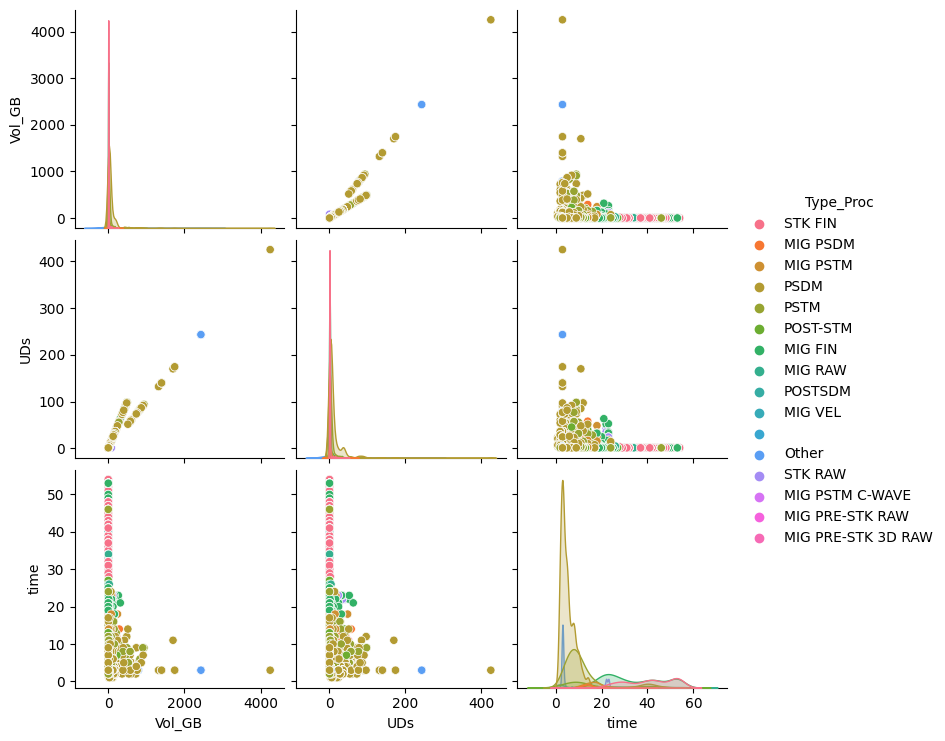

In [321]:
# Scatter Plot com Seaborn - Variação 2
sns.pairplot(df_s_fd, hue = "Type_Proc", height = 2.5);

Conforme mensionado anteriormente, a ANP leva em consideração apenas a informação de volume dos dados para a definição do valor, com isso não observamos nenhuma modificação significativa nos dados ligados a volume e valor.

Com relação ao tempo percebemos como os dados PSDM e PSTM estão mais presentes em projetos mais novos. É interessante pois são dados que exigem mais infra-estrutura tecnológica, o que vem evoluindo com o tempo, pode ser um dos motivos do resultado exposto no gráfico.

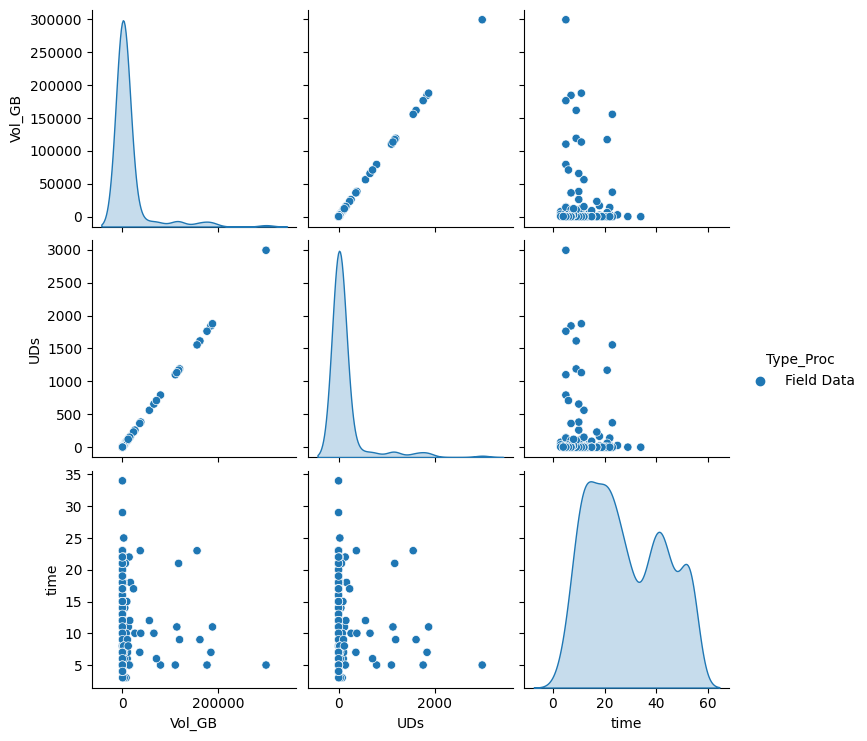

In [322]:
# Scatter Plot com Seaborn - Variação 3
sns.pairplot(df_c_fd, hue = "Type_Proc", height = 2.5);

Os Field Data são os dados gerados diretamente pela aquisição sísmica. Observando os resultados expostos com relação aos dados brutos (Field Data) é possível verificar no tempo uma queda atual na aquisição sísmica, porém no decorrer dos anos anteriores a atividade se mostrou bastante estável.

## 4. Pré-Processamento de Dados

Na etapa de pré-processamento dos dados faremos os ajustes necessários para preparar os dados em sua totalidade. Iniciaremos com a criação de um novo dataset para manter preservado o dataset original e após a criação do novo dataset os ajustes serão descrevitos e executados.

In [405]:
# salvando um NOVO dataset para tratamento

# recuperando os nomes das colunas
col = list(dados_anp.columns)

# o novo dataset será identico ao dataset anterior
programas = dados_anp[col[:]]

### 4.1 Tratamento de Missings e Limpeza

Na parte de análise dos dados foram verificadas algumas falhas textuais e conceituais dentro do dataset, para solucionar o problema iremos realizar a limpeza destes dados. Os ajustes textuais serão realizados com base em conhecimento prévio sobre o banco de dados sísmicos e em seguida iniciaremos os tratamentos de missings.

É interessante perceber que os dados do atributo Type_Proc não apresentam missings, porém, ao serem exibidos anteriormente na área de análise de dados, foram encontrados 36 dados sem informações que também precisarão ser ajustados. Os ajustes serão feitos por partes e serão descritos conforme formos avançando no tratamento dos dados.

Inicialmente classificaremos os tipos de processamento sem informações como desconhecidos.

Após isso consertaremos a nomenclatura das classes de tipo de processamento sísmico, unificando termos com o mesmo significado e ajustando equivocos de preenchimento. Transformaremos informações indesejadas em NaN para posteriormente excluir as linhas.

Em seguida padronizaremos os termos "Sismica 2D" e "Sismica 3D" no atributo ligado a dimensionalidade.

In [406]:
# substituindo os espaços em branco por 'desconhecido' no atributo Type_Proc
programas['Type_Proc'].replace(' ', 'desconhecido', inplace=True)

# Ajustando a nomenclatura do atributo de tipo de processamento
programas['Type_Proc'] = programas['Type_Proc'].replace(['MIG PRE-STK 3D RAW', 'MIG PRE-STK RAW', 'MIG PSTM C-WAVE', 'POSTSDM'], ['MIG RAW', 'MIG RAW', 'MIG PSTM', 'POST-SDM'])

# substituindo as informações de projetos de velocidade por NaN
programas['Type_Proc'].replace('MIG VEL', np.nan, inplace=True)

# substituindo as informações vazias por NaN
programas.replace(' ', np.nan, inplace=True)

# verificando nulls no dataset
programas.isnull().sum()

Vol_GB        1140
UDs           1140
Project         36
Type_Proc        8
Pub              0
Program          0
Type_Prog        0
Dim              0
date_start      18
date_end         0
time             0
date_pub      1683
Bloc          4001
Field         3945
Basin            3
EAD              0
Operator      1544
dtype: int64

In [407]:
# Ajustando a nomenclatura do atributo de dimensionalidade dos dados
programas['Dim'] = programas['Dim'].replace(['Sismica_2D', 'Sismica_3D'], ['Sismica 2D', 'Sismica 3D'])

# Mostrando a distribuição das classes de acordo com a dimensionalidade dos dados corrigida
print (programas.groupby('Dim').size())

Dim
Sismica 2D    2343
Sismica 3D    3440
dtype: int64


Agora iniciaremos a limpeza e os tratamentos nos  atributos que ainda apresentam informações faltantes.

<Axes: >

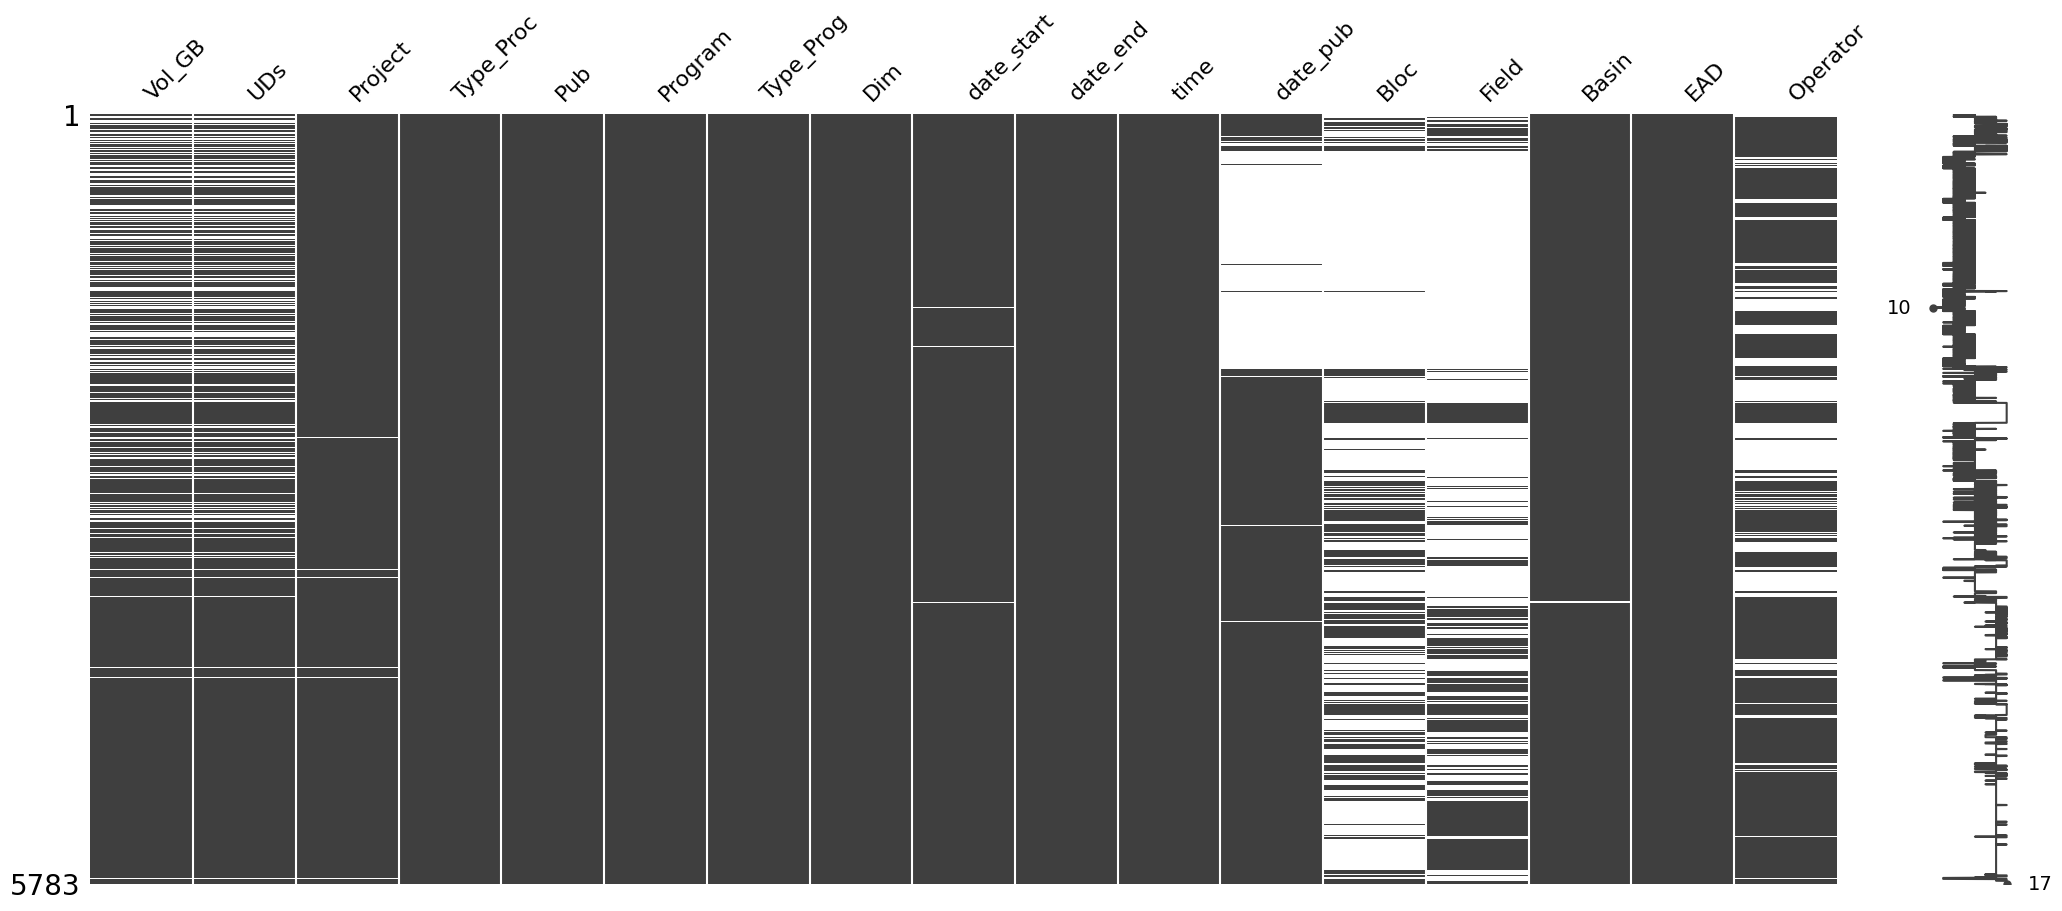

In [408]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

Existem muitas informações faltantes nos dados da ANP. Os atributos da data de publicação, bloco e campo serão excluídos. Também não há informações em alguns dados das colunas de volume e valor na ANP, além da ausência de informações de Operadoras e Projetos.

Alguns programas são realizados por iniciativa das EAD, logo dados com ausência de Operadoras são recorrentes e não representam um problema, mas sim uma situação normal do mercado. Alguns programas não possuem projetos nomeados mas são informações necessárias, logo os missings serão substituídos pelo termo "desconhecido". A mesma solução será utilizada na data de início (date_start).

Os dados de valor não serão importantes nas tomadas de decisão pois fazem parte de uma atribuição da ANP que é diretamente proporcional ao volume, logo as informações de valor também serão removidas.

Sendo a área de localização do dado de extrema importância para o problema que queremos resolver, removeremos também os projetos que não possuam informações de bacia sedimentares.

<Axes: >

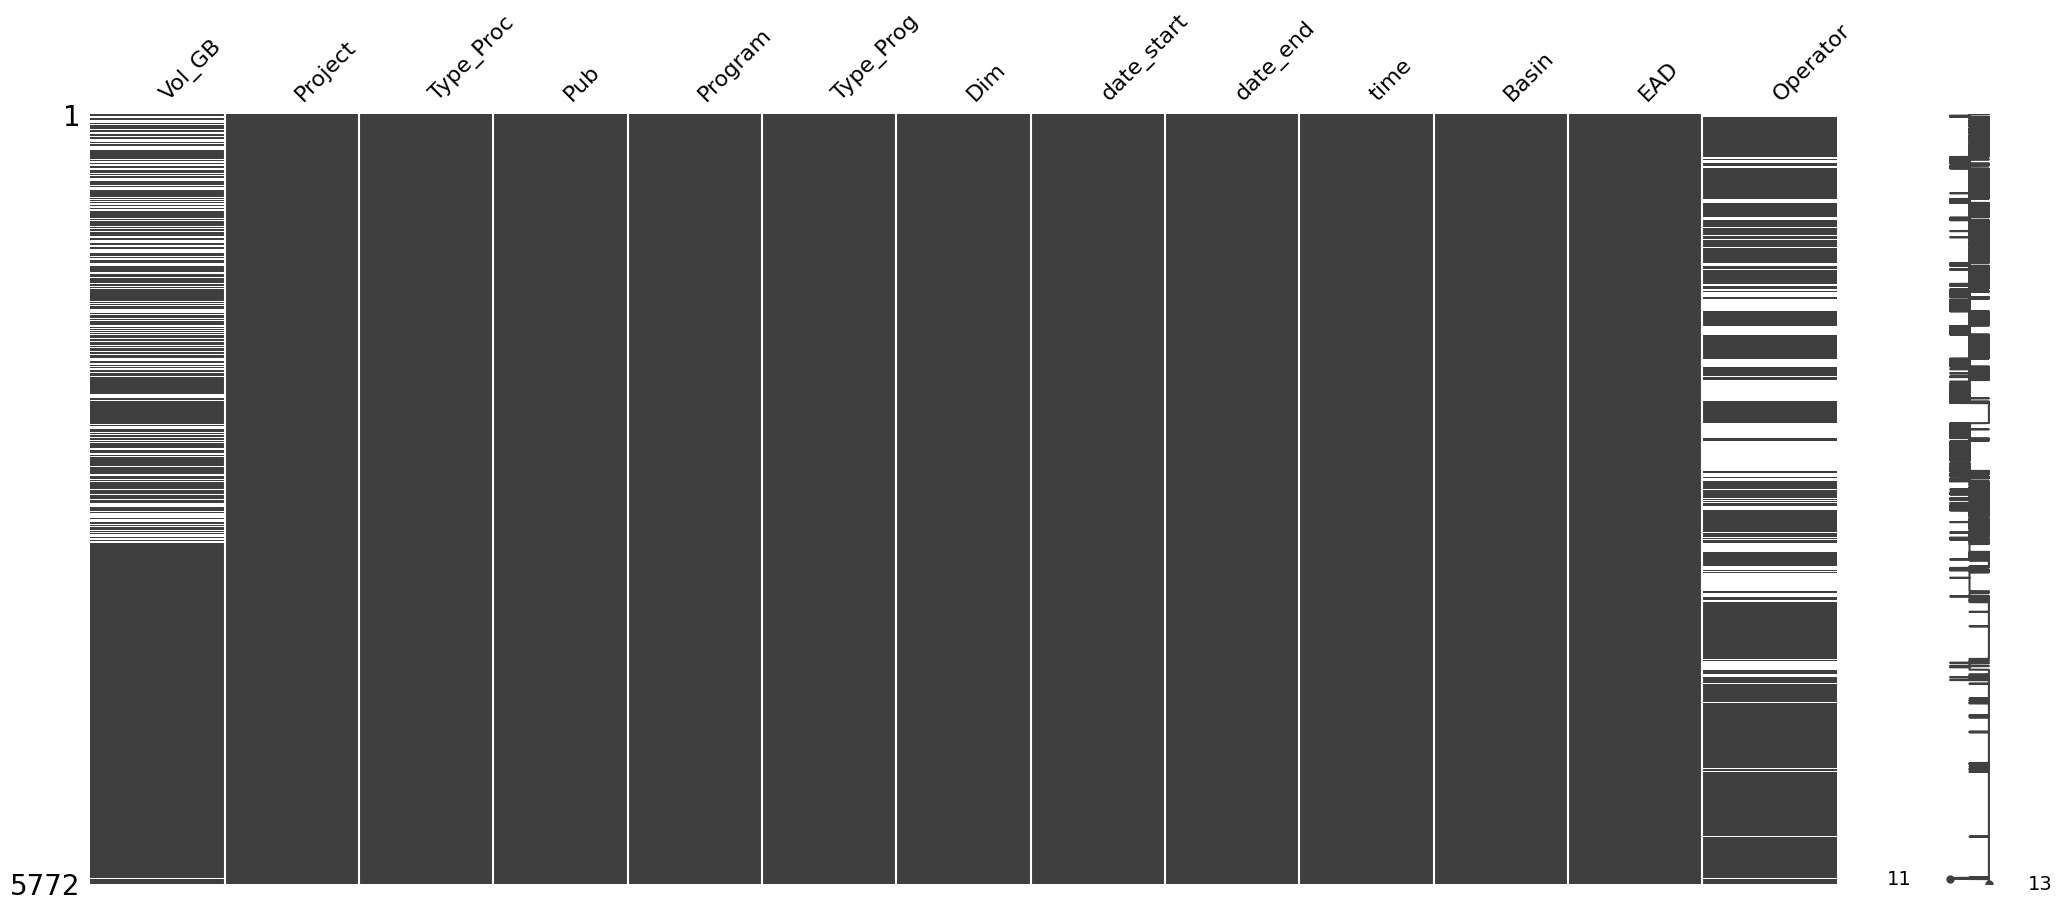

In [409]:
# substituindo os espaços missing por 'desconhecido' no atributo Project e na data inicial
programas['Project'].fillna('desconhecido', inplace=True)
programas['date_start'].fillna('desconhecido', inplace=True)

# removendo as colunas predefinidas devido aos missings ('UDs', 'date_pub', 'Bloc' e 'Field')
programas.drop(['UDs'], axis=1, inplace= True)
programas.drop(['date_pub'], axis=1, inplace= True)
programas.drop(['Bloc'], axis=1, inplace= True)
programas.drop(['Field'], axis=1, inplace= True)

# removendo as linhas com informações nulas de bacia sedimentar
programas = programas[programas['Basin'].notna()]

# removendo as linhas com informações nulas de tipo de processamento
programas = programas[programas['Type_Proc'].notna()]

# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

Na parte de análise de dados comentamos sobre a diferença na questão de volume para dados de campo e dados processados. Com isso faremos o tratamento dos dados faltantes no atributo Vol_GB com duas regras diferentes dentro do mesmo atributo:
 1. Para dados processados utilizaremos a mediana.
 2. Para dados brutos utilizaremos a média.

Essa escolha ocorre depois da observação de valores feita na análise dos dados e se baseia em conhecimento prévio de banco de dados sísmicos além do conhecimento gerado pela experiência neste tipo de dado.

Na prática dividiremos os dados em dois subconjuntos, aplicaremos as regras e concatenaremos os dados novamente formando um novo dataset programas.

Como explicado anteriormente, não haver informações de operadora em dados sísmicos é bastante normal, logo transformaremos os missings do atributo relacionado as empresas operadoras substituindo a ausência de informação com o termo "Dado da EAD".


<Axes: >

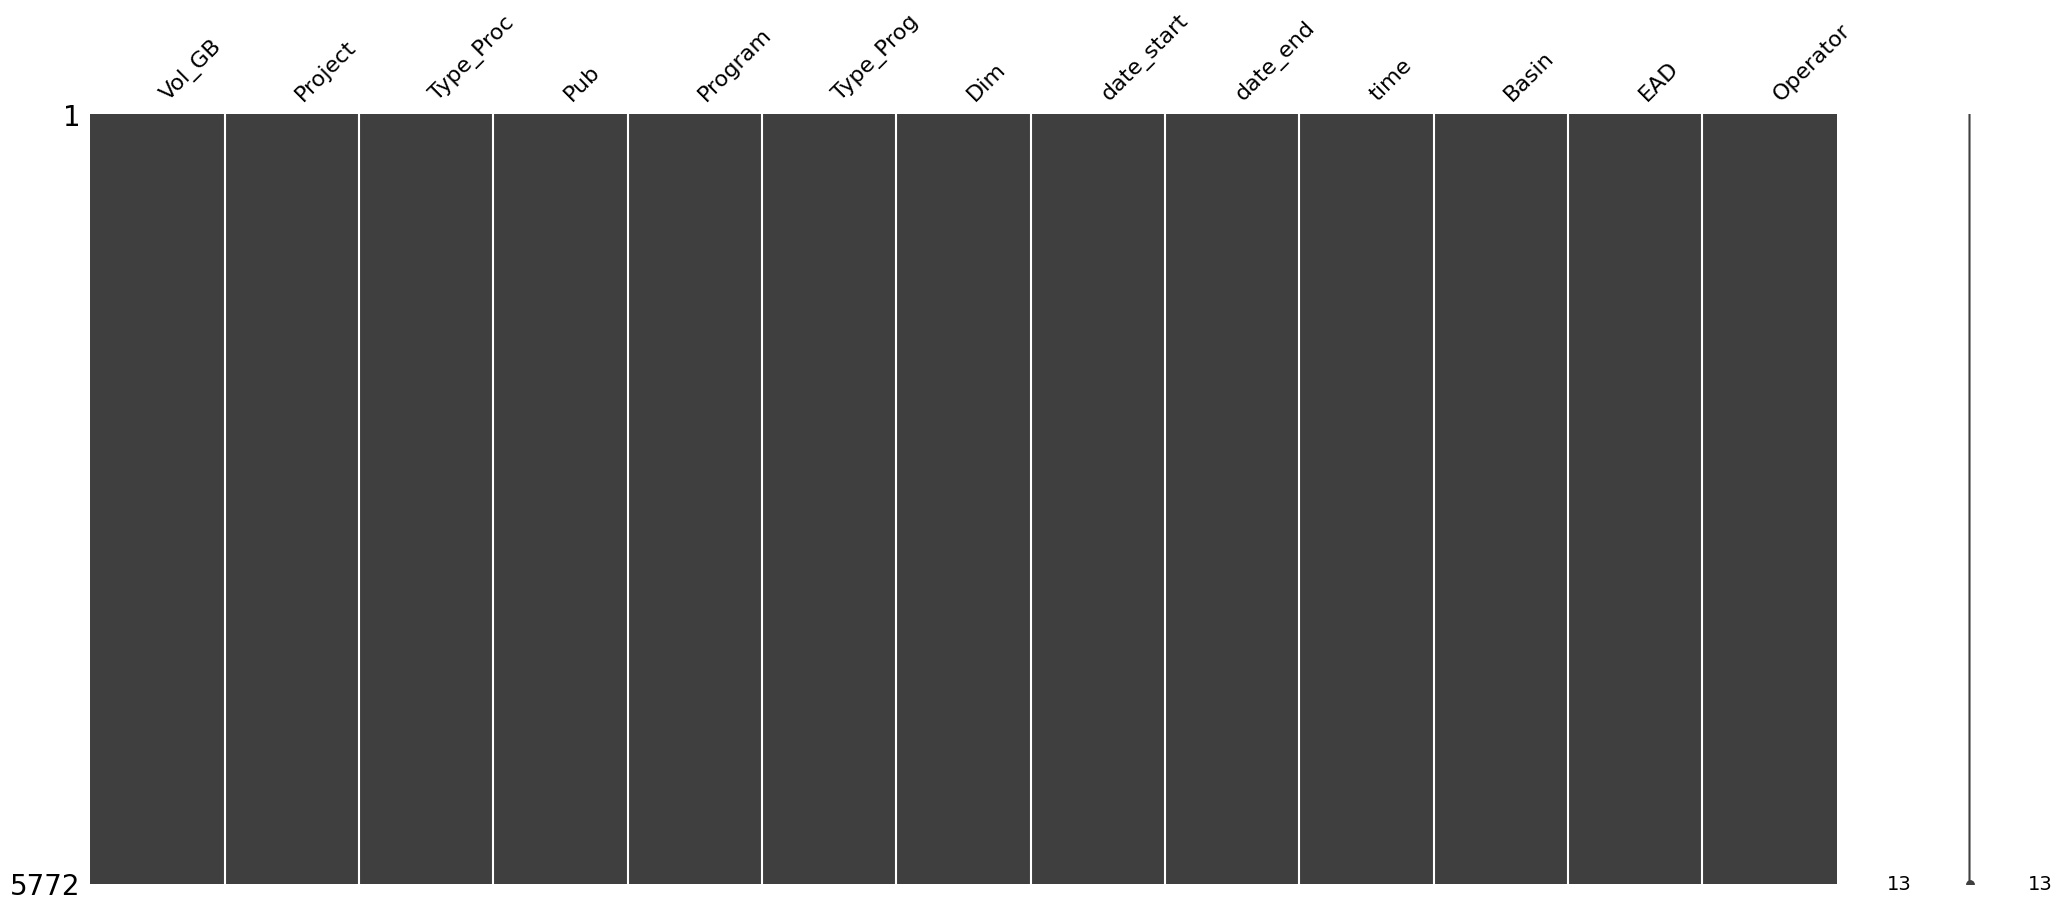

In [410]:
# Criando subconjunto alternativo sem a presença dos dados Brutos
sem_fd= programas.loc[programas['Type_Proc'] != 'Field Data']

# Criando subconjunto alternativo apenas com dados Brutos
com_fd= programas.loc[programas['Type_Proc'] == 'Field Data']

# substituindo os NaN de 'Vol_GB' pela mediana do atributo no subconjunto de dados processados
sem_fd['Vol_GB'].fillna(sem_fd['Vol_GB'].median(), inplace=True)

# substituindo os NaN de 'Vol_GB' pela média do atributo no subconjunto com apenas dados brutos
com_fd['Vol_GB'].fillna(com_fd['Vol_GB'].mean(), inplace=True)

# Concatenando os subconjuntos e gerando o novo dataset programas
programas= pd.concat([sem_fd,com_fd])

# substituindo os faltantes de "Operator" com o termo "Dados da EAD"
programas['Operator'].fillna('Dados da EAD', inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

In [411]:
# verificando novamente nulls no dataset
programas.isnull().sum()

Vol_GB        0
Project       0
Type_Proc     0
Pub           0
Program       0
Type_Prog     0
Dim           0
date_start    0
date_end      0
time          0
Basin         0
EAD           0
Operator      0
dtype: int64

### 4.2 Feature Engineering

Para a resolução do problema e futura adequação a mudanças de cenário do mercado de óleo e gás é interessante a criação de recursos. Serão extraídas caracteristica a partir do atributo da empresa operadora (Operator).Os dados oriundos de áreas de aquisição sísmica ou os dados processados definidos pelas operadoras possuem um critério mais embasado para serem gerados. A Operadora faz um alto investimento em pesquisa antes de gerar qualquer tipo de dado sísmico em uma região, tornando valioza a informação se há ou não uma empresa operadora envolvida.

Será realizado também o enriquecimento do dataset, agregando níveis de importância as bacias sedimentares. Esse enriquecimento levará em consideração o cenário atual da industria de óleo e gás.

In [412]:
programas['has.operator'] = np.where(programas['Operator'] == 'Dados da EAD', 'nao', 'sim')
print(programas.shape)

(5772, 14)


In [363]:
#print(programas.groupby('Basin').size())

In [413]:
# Guardando o novo dataset para testes futuros
datasetSemMissings = programas

# incluindo a coluna 'class' no novo dataset
#datasetSemMissings['class'] = programas['class']

# exibindo as primeiras linhas
datasetSemMissings.head()

,Vol_GB,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,Basin,EAD,Operator,has.operator
0,0.016620,0007_SERGIPE_ALAGOAS_39,STK FIN,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,multiplas,Petrobras,Petrobras,sim
2,18.291451,0022_BRASILSPAN01_PSDM,MIG PSDM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,multiplas,GX Technology,Dados da EAD,nao
3,14.677270,0022_BRASILSPAN01_PSTM,MIG PSTM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,multiplas,GX Technology,Dados da EAD,nao
5,48.240106,0022_GREATERBRASILSPAN,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,multiplas,GX Technology,Dados da EAD,nao
6,9.820742,0022_GREATERBRASILSPAN_SUBSET1,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,multiplas,GX Technology,Dados da EAD,nao


### 4.3. Separação em conjunto de treino e conjunto de teste